Data taken from: http://jmcauley.ucsd.edu/data/amazon/

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
data_sources = [
  ('Baby', 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Baby_5.json.gz'), 
  ('Muscial_Instruments', 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Musical_Instruments_5.json.gz'), 
  ('Electronics', 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics_5.json.gz'),
  ('Movies_and_TV', 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Movies_and_TV_5.json.gz')
]

In [3]:
%time
import urllib.request
import os

output_dir = 'data/'
os.makedirs(os.path.dirname(output_dir), exist_ok=True)

for (_, source_data_location) in data_sources:
    print(f'Processing {source_data_location}:')
    file = source_data_location.split('/')[-1]
    target_path = output_dir+file
    if os.path.exists(target_path):
        print('  Already exists.')
        continue

    # Unzipped already?
    if os.path.exists(target_path[:-3]):
        print('  Already exists, unzipped.')
        continue

    print('Downloading.')
    with urllib.request.urlopen(source_data_location) as response:
        buffer = response.read()
        print('Downloaded.')
    with open(target_path, 'wb') as f:  
        f.write(buffer)
        print('Written.')


CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.53 µs
Processing http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Baby_5.json.gz:
  Already exists, unzipped.
Processing http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Musical_Instruments_5.json.gz:
  Already exists, unzipped.
Processing http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics_5.json.gz:
  Already exists, unzipped.
Processing http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Movies_and_TV_5.json.gz:
  Already exists, unzipped.


In [4]:
!ls -ltrh data

total 3.9G
-rw-rw-r-- 1 ec2-user ec2-user 116M Mar  2 12:15 reviews_Baby_5.json
-rw-rw-r-- 1 ec2-user ec2-user 7.2M Mar  2 12:15 reviews_Musical_Instruments_5.json
-rw-rw-r-- 1 ec2-user ec2-user 1.4G Mar  2 12:16 reviews_Electronics_5.json
-rw-rw-r-- 1 ec2-user ec2-user 1.9G Mar  2 12:19 reviews_Movies_and_TV_5.json
-rw-rw-r-- 1 ec2-user ec2-user 338M Mar  2 12:54 train.csv
-rw-rw-r-- 1 ec2-user ec2-user 130M Mar  2 12:54 validation.csv


In [5]:
%time
!cd data; gunzip -f *.gz; ls -ltrh

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 4.77 µs
gzip: *.gz: No such file or directory
total 3.9G
-rw-rw-r-- 1 ec2-user ec2-user 116M Mar  2 12:15 reviews_Baby_5.json
-rw-rw-r-- 1 ec2-user ec2-user 7.2M Mar  2 12:15 reviews_Musical_Instruments_5.json
-rw-rw-r-- 1 ec2-user ec2-user 1.4G Mar  2 12:16 reviews_Electronics_5.json
-rw-rw-r-- 1 ec2-user ec2-user 1.9G Mar  2 12:19 reviews_Movies_and_TV_5.json
-rw-rw-r-- 1 ec2-user ec2-user 338M Mar  2 12:54 train.csv
-rw-rw-r-- 1 ec2-user ec2-user 130M Mar  2 12:54 validation.csv


In [6]:
!head -n1 data/reviews_Electronics_5.json | python -m json.tool

{
    "reviewerID": "AO94DHGC771SJ",
    "asin": "0528881469",
    "reviewerName": "amazdnu",
    "helpful": [
        0,
        0
    ],
    "reviewText": "We got this GPS for my husband who is an (OTR) over the road trucker.  Very Impressed with the shipping time, it arrived a few days earlier than expected...  within a week of use however it started freezing up... could of just been a glitch in that unit.  Worked great when it worked!  Will work great for the normal person as well but does have the \"trucker\" option. (the big truck routes - tells you when a scale is coming up ect...)  Love the bigger screen, the ease of use, the ease of putting addresses into memory.  Nothing really bad to say about the unit with the exception of it freezing which is probably one in a million and that's just my luck.  I contacted the seller and within minutes of my email I received a email back with instructions for an exchange! VERY impressed all the way around!",
    "overall": 5.0,
    "summary

In [7]:
import sagemaker
from sagemaker import get_execution_role
import json
import boto3

sess = sagemaker.Session()

role = get_execution_role()
print(role) 

bucket = 'mkamp-amazon-reviews' 
print(bucket)
prefix = 'data' 

arn:aws:iam::811243659808:role/service-role/AmazonSageMaker-ExecutionRole-20180113T174439
mkamp-amazon-reviews


In [8]:
from random import shuffle
import multiprocessing
from multiprocessing import Pool
import csv
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
import pandas as pd

def transform_input_records(label, review_lines_json_file_path, n_samples=None):
    records = pd.read_json(review_lines_json_file_path, lines=True)
    if n_samples:
        records = records.sample(n_samples, replace=True)

    records['label'] = label
    return records[['label', 'reviewText']]

In [10]:
import numpy as np

def preprocess_partition(partition):
    func = lambda s: ' '.join(nltk.word_tokenize(s.lower()))
    
    partition.reviewText = partition.reviewText.apply(func)
    return partition

def preprocess_data(rows, n_samples=None):
    num_cpus = multiprocessing.cpu_count()
    print(f'cpus: {num_cpus}')
    row_partitions = np.array_split(rows, num_cpus*10)
    pool = Pool(processes=num_cpus)
    partial_results = pool.map(preprocess_partition, row_partitions)
    
    transformed_rows = pd.concat(partial_results)

    pool.close() 
    pool.join()
    return transformed_rows

In [11]:
%%time
all_data = pd.concat([transform_input_records(label, data_source_location, 200000) for (label, data_source_location) in data_sources])

CPU times: user 1min 10s, sys: 15.7 s, total: 1min 25s
Wall time: 4min 58s


In [12]:
display(all_data[:5])

,label,reviewText
134856,Baby,We had a previous iteration of this product th...
71799,Baby,These are an ok option. Easy to hold and a goo...
51956,Baby,I spent a lot of time reviewing comments onlin...
159953,Baby,This is a great nursing pillow- it's plush yet...
97073,Baby,My 4 month old loves this little toy she has a...


In [13]:
all_data = all_data.sample(frac=1).reset_index(drop=True)

In [14]:
all_data.describe()

,label,reviewText
count,800000,800000
unique,4,501953
top,Muscial_Instruments,
freq,200000,349


In [15]:
n = len(all_data)
print(n)
print(all_data.groupby('label').size()/n)

800000
label
Baby                   0.25
Electronics            0.25
Movies_and_TV          0.25
Muscial_Instruments    0.25
dtype: float64


In [16]:
all_data = preprocess_data(all_data)

cpus: 8


In [17]:
%%time
#from sklearn.model_selection import train_test_split
#train_data, validation_data = train_test_split(all_data, test_size=0.3)
splits = [0.65, 0.9]
split_indices = [int(n*split) for split in splits]
train_data, validation_data, test_data = np.split(all_data, split_indices)
print(len(train_data), len(validation_data), len(test_data))

520000 200000 80000
CPU times: user 48.5 ms, sys: 4.07 ms, total: 52.6 ms
Wall time: 52 ms


In [18]:
#__label__EmailInboxFireClaims My house burned down <email text>.

In [19]:
%%time

def write_data(data, path):
    with open(path, 'w') as f:
        for index, row in data.iterrows():
            f.write(f'__label__{row.label} {row.reviewText}\n')
write_data(train_data, output_dir+'train.csv')
write_data(validation_data, output_dir+'validation.csv')

CPU times: user 46.4 s, sys: 594 ms, total: 46.9 s
Wall time: 51.4 s


In [20]:
!head -n3 data/validation.csv

__label__Electronics i bought the little speakers for his i pod and thoughtthis would be perfect , for them and it is . he just loves his speaker and thesplitter works great .
__label__Movies_and_TV will ferrell is one of my favorite comic personalities . revisiting his time on snl with this dvd is truly a good time.there are plenty of skits on the dvd that people are well familiar with , such as the james lipton skit , craig the spartan cheerleader , harry caray , etc . yet some of these skits had escaped my attention , like the `` dissing your dog '' skit . i had to watch parts of that one a few times over ... hilarious . will ferrell never disappoints me.the dvd also features bonus material . will ferrell 's original audition footage is included , as are outtakes and a few memorable appearances on late night with conan o'brien.this is a great buy .
__label__Electronics i have bought this item like 2 years ago and still working perfect and accomplishing the purpose it was invented .


In [21]:
%%time

train_channel = prefix + '/train'
validation_channel = prefix + '/validation'

sess.upload_data(path=output_dir+'train.csv', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path=output_dir+'validation.csv', bucket=bucket, key_prefix=validation_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)

s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

print (s3_train_data, s3_validation_data, s3_output_location)

s3://mkamp-amazon-reviews/data/train s3://mkamp-amazon-reviews/data/validation s3://mkamp-amazon-reviews/data/output
CPU times: user 3.55 s, sys: 2.55 s, total: 6.1 s
Wall time: 3 s


In [22]:
region_name = boto3.Session().region_name

In [23]:
container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")
print('Using SageMaker BlazingText container: {} ({})'.format(container, region_name))

Using SageMaker BlazingText container: 685385470294.dkr.ecr.eu-west-1.amazonaws.com/blazingtext:latest (eu-west-1)


In [24]:
bt_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.c4.4xlarge',
                                         train_volume_size = 30,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

In [25]:
bt_model.set_hyperparameters(mode="supervised",
                            epochs=10,
                            min_count=2,
                            learning_rate=0.05,
                            vector_dim=10,
                            early_stopping=True,
                            patience=4,
                            min_epochs=5,
                            word_ngrams=2)

In [26]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='text/plain', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='text/plain', s3_data_type='S3Prefix')
data_channels = {'train': train_data, 'validation': validation_data}

In [27]:
bt_model.fit(inputs=data_channels, logs=True)

INFO:sagemaker:Creating training-job with name: blazingtext-2019-03-02-13-33-17-678


2019-03-02 13:33:17 Starting - Starting the training job...
2019-03-02 13:33:19 Starting - Launching requested ML instances...
2019-03-02 13:34:17 Starting - Preparing the instances for training......
2019-03-02 13:35:13 Downloading - Downloading input data...
2019-03-02 13:35:29 Training - Training image download completed. Training in progress.
Arguments: train
[03/02/2019 13:35:30 WARNING 140400350426944] Loggers have already been setup.
[03/02/2019 13:35:30 WARNING 140400350426944] Loggers have already been setup.
[03/02/2019 13:35:30 INFO 140400350426944] nvidia-smi took: 0.0251641273499 secs to identify 0 gpus
[03/02/2019 13:35:30 INFO 140400350426944] Running single machine CPU BlazingText training using supervised mode.
[03/02/2019 13:35:30 INFO 140400350426944] Processing /opt/ml/input/data/train/train.csv . File size: 337 MB
[03/02/2019 13:35:30 INFO 140400350426944] Processing /opt/ml/input/data/validation/validation.csv . File size: 129 MB
Read 10M words
Read 20M words
Read

In [28]:
text_classifier = bt_model.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')

INFO:sagemaker:Creating model with name: blazingtext-2019-03-02-13-36-59-737
INFO:sagemaker:Creating endpoint with name blazingtext-2019-03-02-13-33-17-678


---------------------------------------------------------------!

In [29]:
print(all_data.iloc[5].reviewText)

i just did n't know what i was getting . i do n't like this one . i did n't even watch all of them . the first one was so bad .


In [30]:
display(all_data)

,label,reviewText
0,Electronics,i preordered these headphones last summer as a...
1,Movies_and_TV,ghosts and demons of all shapes and forms come...
2,Muscial_Instruments,i have the snark 2 but read that this was the ...
3,Electronics,"very simple , slim case . fits perfect . looks..."
4,Baby,works well in our bumbleride stroller . especi...
5,Movies_and_TV,i just did n't know what i was getting . i do ...
6,Movies_and_TV,everyone in city island has a secret . you wil...
7,Muscial_Instruments,even though i have a tuner in my pedalboard se...
8,Electronics,i upgraded my maps in one garmin gps and insta...
9,Baby,this stroller is exactly what i was looking fo...


In [31]:
test_phrases = [(label, test_data[test_data.label == label].iloc[10].reviewText) for (label, _) in data_sources]
display(test_phrases)

[('Baby',
  "i received this free with my recent purchase of a new britax marathon carseat . it fits the car seat just fine , but must be placed where indicated on the instructions , which puts it just out of reach of my 10 month-old . i think this will work better when he 's older , but it 's useless until then . i think there are probably better options out there -- glad i did n't pay for it ."),
 ('Muscial_Instruments',
  'this stand is very stable and easy to put together . works perfect for keeping my guitar safe from being knocked over .'),
 ('Electronics',
  "after reading some of the reviews i was a little skeptical about the kingston micro 's performance and speed . these convenient memory mini sticks work beautifully . i was quite impressed its quality and speed , as well as the very reasonable price . kingston is as good or better than any of the other brands out there ."),
 ('Movies_and_TV',
  'fast service , good condition when it got here no problems , will probably order

In [32]:
%%time

phrases = [phrase for (label, phrase) in test_phrases]
print('labels:', [label for (label, _) in test_phrases])

# using the same nltk tokenizer that we used during data preparation for training
#tokenized_sentences = [' '.join(nltk.word_tokenize(sent)) for sent in sentences]

payload = {"instances" : phrases, 
           "configuration": {"k": 2}}

response = text_classifier.predict(json.dumps(payload))

predictions = json.loads(response)
print(json.dumps(predictions, indent=2))

labels: ['Baby', 'Muscial_Instruments', 'Electronics', 'Movies_and_TV']
[
  {
    "prob": [
      0.9972860217094421,
      0.002478039590641856
    ],
    "label": [
      "__label__Baby",
      "__label__Electronics"
    ]
  },
  {
    "prob": [
      1.0000098943710327,
      1.0059728083433583e-05
    ],
    "label": [
      "__label__Muscial_Instruments",
      "__label__Electronics"
    ]
  },
  {
    "prob": [
      0.9996287822723389,
      0.00013893464347347617
    ],
    "label": [
      "__label__Electronics",
      "__label__Muscial_Instruments"
    ]
  },
  {
    "prob": [
      0.7747838497161865,
      0.22514867782592773
    ],
    "label": [
      "__label__Electronics",
      "__label__Movies_and_TV"
    ]
  }
]
CPU times: user 12.4 ms, sys: 0 ns, total: 12.4 ms
Wall time: 172 ms


In [33]:
%%time

test_sample = test_data.sample(5000)

phrases = [review.reviewText for (index, review) in test_sample.iterrows()]

print(f'Inferring classes for {len(phrases)} phrases.')

payload = {"instances" : phrases}

response = text_classifier.predict(json.dumps(payload))

predictions = json.loads(response)

print(f'Number of predictions: {len(predictions)}')
matched = np.array(([prediction['label'][0] == f'__label__{test_sample.iloc[index].label}' for (index, prediction) in enumerate(predictions)]))
acc = (matched == True).sum()/len(matched)
print(f'accuracy: {acc:.3}')


Inferring classes for 5000 phrases.
Number of predictions: 5000
accuracy: 0.987
CPU times: user 669 ms, sys: 10.4 ms, total: 679 ms
Wall time: 1.19 s


In [34]:
%%time
from sklearn.metrics import confusion_matrix

test_sample = test_data.sample(5000)

phrases = [review.reviewText for (index, review) in test_sample.iterrows()]

print(f'Inferring classes for {len(phrases)} phrases.')

payload = {"instances" : phrases}

response = text_classifier.predict(json.dumps(payload))

predictions = json.loads(response)

predicted = [prediction['label'][0][9:] for prediction in predictions]
actual = test_sample.label

acc = (actual == predicted).sum()/len(predicted)
print(f'accuracy: {acc:.3}')


Inferring classes for 5000 phrases.
accuracy: 0.988
CPU times: user 301 ms, sys: 7.66 ms, total: 309 ms
Wall time: 799 ms


Automatically created module for IPython interactive environment
Confusion matrix, without normalization
[[1225   13    1    2]
 [  19 1236    7    4]
 [   2    7 1207    0]
 [   0    3    0 1274]]
Normalized confusion matrix
[[9.87e-01 1.05e-02 8.06e-04 1.61e-03]
 [1.50e-02 9.76e-01 5.53e-03 3.16e-03]
 [1.64e-03 5.76e-03 9.93e-01 0.00e+00]
 [0.00e+00 2.35e-03 0.00e+00 9.98e-01]]


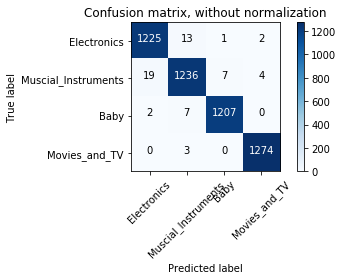

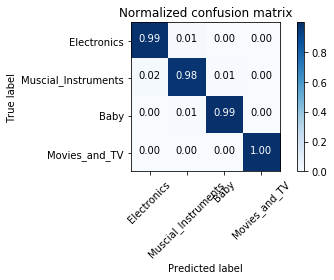

In [35]:
print(__doc__)

import itertools
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

class_names = test_sample.label.unique()


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(actual, predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [36]:
# Don't forget to delete the endpoint otherwise you get billed for it

In [37]:
sess.delete_endpoint(text_classifier.endpoint)

INFO:sagemaker:Deleting endpoint with name: blazingtext-2019-03-02-13-33-17-678
